In [88]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [89]:
# read in all the names:
words = open("names.txt", "r").read().splitlines()
len(words)

32033

In [90]:
chars = sorted(set(''.join(words)))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = { i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [91]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], [] 
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [92]:
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        # Randomized weights from a gaussian and then the initialization optimization
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # 'fan_in**0.5' - will conserved the std of 1 / this fan_in**0.5 is not neccessery if we use batchnorm
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [93]:
# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters which trained with backpropagation:
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers which trained with running 'momentum' update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # Calculate the forward pass based on the paper: https://arxiv.org/abs/1502.03167
        if self.training: # if we would evaluate we dont want to train the network
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            # Important to use ._no_grad() here to not build the computational graph for the 'running_*' parameters 
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [94]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [95]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g) # Embedding matrix

# Without the activation function, the network would just collapse into one Linear layer, so there is not possible to train deep networks.
# But papers proved that deeper layers perform better.
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer (softmax layer): make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1 # if we do not use BatchNorm
    # all other layers: apply gain (from the paper)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # 5/3 is the 'gain' for tanh activation
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [96]:
def training_ntw(epoch, batch_size, X, Y, lossi=[], ud=[]):
    
    for i in range(epoch):
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        Xb, Yb = X[ix], Y[ix] # batch X,Y
        
        # Forward pass:
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # Backward pass:
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # Update:
        lr = 0.1 if i < 1000000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # Track stats:
        if i % 10000 == 0:
            print(f'{i:7d}/{epoch:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item)
        
        with torch.no_grad():
            # grad.std / data.std - basically how are the updates to the values in these tensors
            ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
        
        if i == 1000:
            break # AFTER DEBUG: would take out obviously to run the full optimization

In [97]:
lossi = []
ud = []

      0/  20000: 3.2870


In [102]:
training_ntw(20000, 32, Xtr, Ytr, lossi, ud)

      0/  20000: 2.6473


## Important metrics to visualize:

layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.91%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 3.19%
layer 8 (      Tanh): mean -0.01, std 0.65, saturated: 3.09%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 2.59%
layer 14 (      Tanh): mean -0.01, std 0.66, saturated: 2.22%


Text(0.5, 1.0, 'activation distribution')

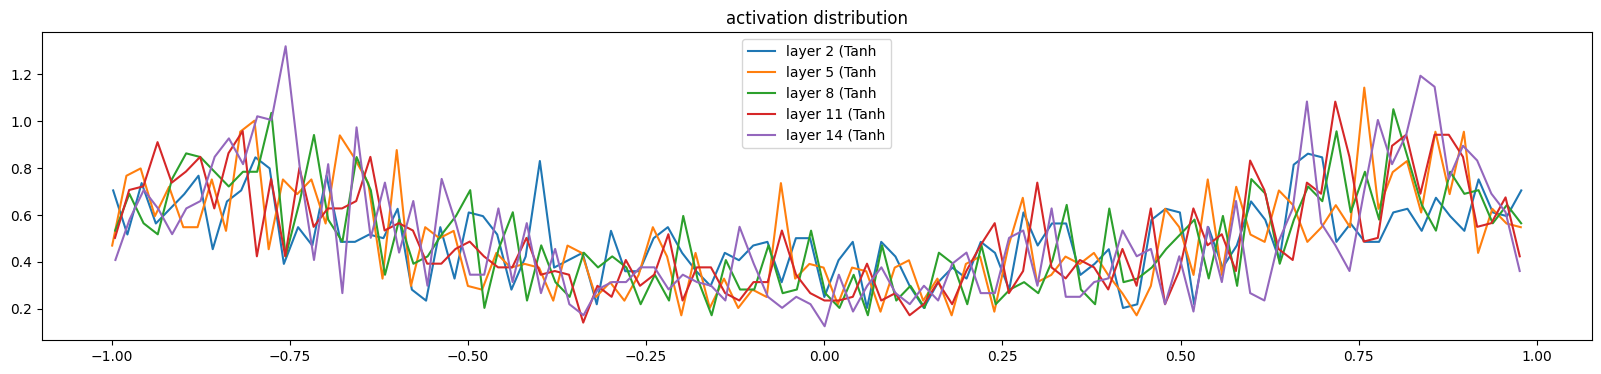

In [103]:
# visualize histograms: output of the layer
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh): # If it is a Tanh layer
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

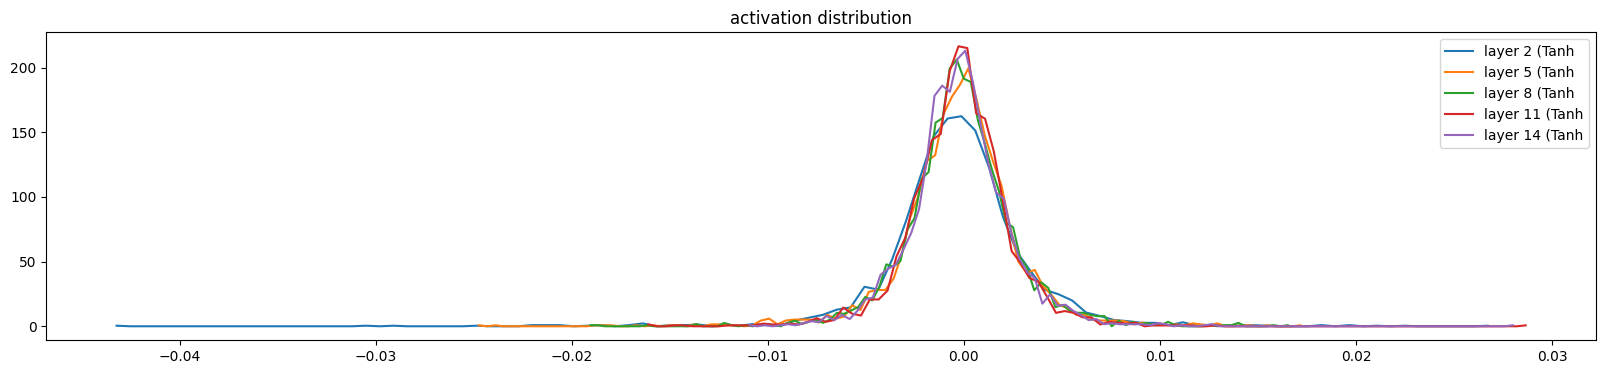

In [104]:
# visualize histograms: gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 1.310867e-02 | grad:data ratio 1.308937e-02
weight  (30, 100) | mean -0.000048 | std 7.983692e-03 | grad:data ratio 2.546149e-02
weight (100, 100) | mean -0.000017 | std 6.499221e-03 | grad:data ratio 3.856057e-02
weight (100, 100) | mean +0.000013 | std 5.875574e-03 | grad:data ratio 3.462779e-02
weight (100, 100) | mean +0.000024 | std 5.652805e-03 | grad:data ratio 3.349940e-02
weight (100, 100) | mean -0.000028 | std 5.108915e-03 | grad:data ratio 3.029510e-02
weight  (100, 27) | mean -0.000110 | std 1.006077e-02 | grad:data ratio 5.938504e-02


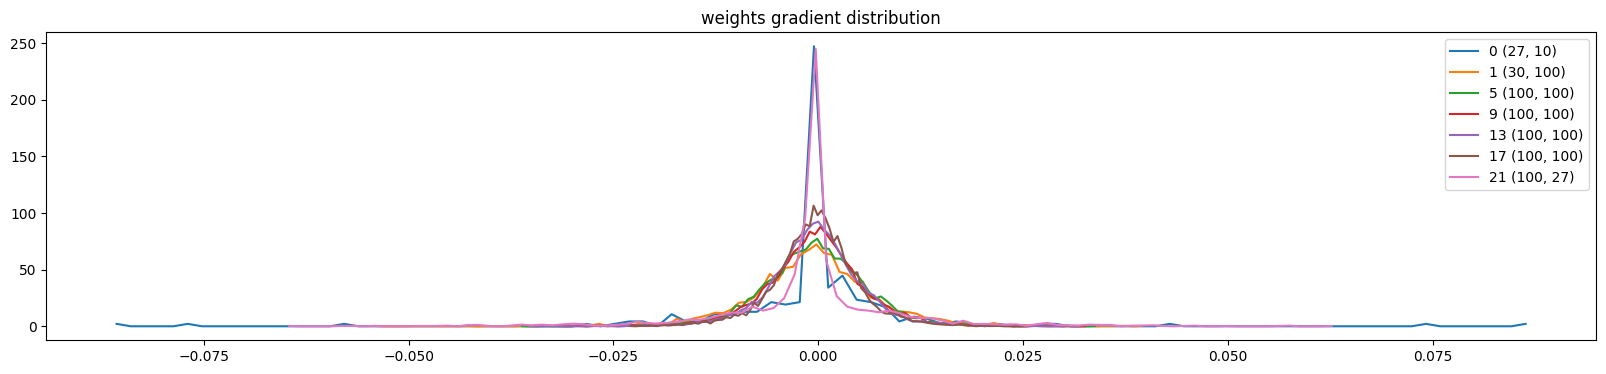

In [105]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

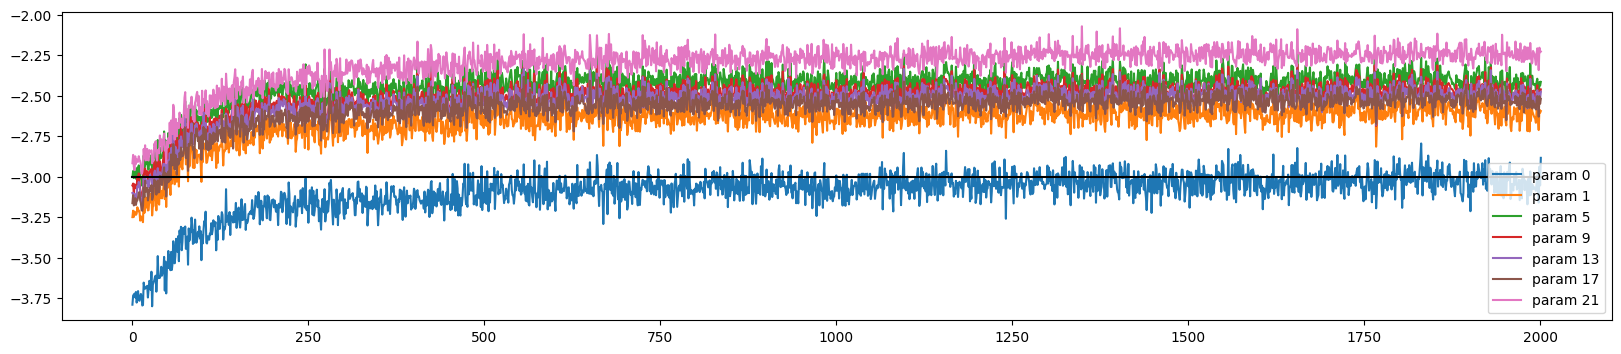

In [106]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);